In [202]:
# Import cell
import pathlib
from collections import defaultdict
import json
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

###  regress targetting returnss, and take regressor from ´company´ to ´similarity_score´ but also : company, Sector, DJIA previous year return.

In [206]:
def train_model_and_save_predictions(train_end_year, prediction_year, data_path, output_folder):
    """
    Trains a regression model using data up to train_end_year, writes the regression summary to a file
    in the output folder, computes MSE on both the full test set and the re-prediction for prediction_year,
    predicts returns for prediction_year, ranks the stocks, and saves the predictions.
    
    Parameters:
      train_end_year: int - last year to include in training data.
      prediction_year: int - the year for which predictions are made.
      data_path: str - path to the merged data CSV.
      output_folder: str - folder where the predictions and summary file will be saved.
    
    Returns:
      results: the fitted regression model.
    """
    # Load the merged data
    df = pd.read_csv(data_path)

    # Keep all columns including Company, Sector, and DJIA_Return_Previous_Year
    columns_to_keep = [
        "Year", "Company", "sentiment_score_positive", "sentiment_score_negative",
        "sentiment_score_polarity", "sentiment_score_subjectivity", "similarity_score",
        "DJIA_Return_Previous_Year", "Yearly_Return", "Sector"
    ]
    df = df[columns_to_keep]

    # One-hot encode the 'Company' column
    encoder_company = OneHotEncoder(sparse_output=False, drop='first')
    company_encoded = encoder_company.fit_transform(df[['Company']])
    company_encoded_df = pd.DataFrame(company_encoded, columns=encoder_company.get_feature_names_out(['Company']))

    # One-hot encode the 'Sector' column
    encoder_sector = OneHotEncoder(sparse_output=False, drop='first')
    sector_encoded = encoder_sector.fit_transform(df[['Sector']])
    sector_encoded_df = pd.DataFrame(sector_encoded, columns=encoder_sector.get_feature_names_out(['Sector']))

    # Concatenate the encoded columns with the original dataframe
    df = pd.concat([df.reset_index(drop=True), 
                    company_encoded_df.reset_index(drop=True), 
                    sector_encoded_df.reset_index(drop=True)], axis=1)

    # Define target and features
    target = "Yearly_Return"
    features = [
        "sentiment_score_positive", "sentiment_score_negative",
        "sentiment_score_polarity", "sentiment_score_subjectivity", "similarity_score",
        "DJIA_Return_Previous_Year"
    ] + list(company_encoded_df.columns) + list(sector_encoded_df.columns)

    # Sort data by Year to maintain time order
    df.sort_values("Year", inplace=True)

    # Split data: training on data up to train_end_year and testing on later years
    train_data = df[df["Year"] <= train_end_year]
    test_data  = df[df["Year"] > train_end_year]

    X_train = train_data[features]
    y_train = train_data[target]

    # Build and train the model
    X_train_const = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_const)
    results = model.fit()

    # Write the regression summary to a file in the output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    summary_file = os.path.join(output_folder, f"regression_summary_{prediction_year}.txt")
    with open(summary_file, "w") as f:
        f.write(results.summary().as_text())
    print(f"Regression summary saved to {summary_file}")

    # Evaluate on full test set (years > train_end_year)
    X_test = test_data[features]
    y_test = test_data[target]
    X_test_const = sm.add_constant(X_test, has_constant='add')


    # print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}, X_test_const shape: {X_test_const.shape}")

  
    y_pred = results.predict(X_test_const) # Predictions on the test set

    mse_test = mean_squared_error(y_test, y_pred)
    print(f"MSE on full test set (years > {train_end_year}): {mse_test:.4f}")







    ################################################
    # Evaluate on re-prediction for prediction_year
    ################################################
  
    # Predict for the specific prediction_year
    prediction_data = df[df["Year"] == prediction_year].copy()
    X_pred = prediction_data[features]
    # Align columns with training data
    X_pred = X_pred.reindex(columns=X_train.columns, fill_value=0)
    X_pred_const = sm.add_constant(X_pred, has_constant='add')
    predicted_returns = results.predict(X_pred_const)
    prediction_data['Predicted_Return'] = predicted_returns

    # Calculate MSE for the re-prediction on prediction_year
    mse_prediction = mean_squared_error(prediction_data[target], prediction_data['Predicted_Return'])
    print(f"MSE on re-prediction for {prediction_year}: {mse_prediction:.4f}")

    # Keep only necessary columns and add rankings
    prediction_data = prediction_data[['Year', 'Company', 'Yearly_Return', 'Predicted_Return']]
    prediction_data['Predicted_Return_Rank'] = prediction_data['Predicted_Return'].rank(method='min', ascending=False)
    prediction_data['Yearly_Return_Rank'] = prediction_data['Yearly_Return'].rank(method='min', ascending=False)

    # Save predictions sorted by predicted and actual return ranks
    file_pred = os.path.join(output_folder, f"{prediction_year}_by_predicted.csv")
    file_actual = os.path.join(output_folder, f"{prediction_year}_by_actual.csv")
    prediction_data.sort_values(by='Predicted_Return_Rank').to_csv(file_pred, index=False)
    prediction_data.sort_values(by='Yearly_Return_Rank').to_csv(file_actual, index=False)
    print(f"Predictions for {prediction_year} saved successfully in {output_folder}!")

    return results






def compute_strategy_returns(prediction_file, djia_file, year):
    """
    Computes the long-short strategy return using the predictions file,
    and compares it to the DJIA return for the given year.
    
    Parameters:
      prediction_file: str - path to the predictions CSV sorted by predicted returns.
      djia_file: str - path to the DJIA returns CSV.
      year: int - the year for which to compute the returns.
      
    Returns:
      A tuple (strategy_return, djia_return).
    """
    # Load the predictions file
    df_pred = pd.read_csv(prediction_file)
    n = len(df_pred)
    n_quartile = int(np.ceil(n * 0.25))
    
    # Sort by Predicted_Return_Rank (lowest rank = highest predicted return)
    df_pred_sorted = df_pred.sort_values(by='Predicted_Return_Rank')
    long_positions = df_pred_sorted.head(n_quartile)
    short_positions = df_pred_sorted.tail(n_quartile)
    
    long_return = long_positions['Yearly_Return'].mean()
    short_return = short_positions['Yearly_Return'].mean()
    
    # Long-short portfolio return
    strategy_return = long_return - short_return

    # Load DJIA data and extract the DJIA return for the year
    df_djia = pd.read_csv(djia_file)
    df_djia['Year'] = pd.to_datetime(df_djia['Date']).dt.year
    djia_year = df_djia[df_djia['Year'] == year]
    if djia_year.empty:
        raise ValueError(f"No DJIA return data found for {year}.")
    djia_return = djia_year.iloc[0]['^DJI']
    
    # Output the results
    print(f"{year} Trading Strategy Results:")
    print(f"Strategy Return: {strategy_return * 100:.2f}% | DJIA Return: {djia_return * 100:.2f}% | Excess Return (Strategy vs DJIA): {(strategy_return - djia_return) * 100:.2f}%")
    
    return strategy_return, djia_return

In [207]:
# Define the simulation years and file paths
simulation_years = [2021, 2022, 2023, 2024]
data_path = "trading_strat_data/merged_data.csv"
djia_file = "trading_strat_data/yearly_djia_returns.csv"

# Loop through each simulation year
for year in simulation_years:
    train_end_year = year - 1  # use data up to the previous year
    output_folder = f"trading_strat_data/{year}_returns_predictions"
    
    print(f"\n--- Simulation for {year} (trained on data up to {train_end_year}) ---")
    
    # Train model and save predictions for the simulation year
    model_results = train_model_and_save_predictions(
        train_end_year=train_end_year,
        prediction_year=year,
        data_path=data_path,
        output_folder=output_folder
    )
    
    # Compute and display the trading strategy returns for the simulation year
    compute_strategy_returns(
        prediction_file=f"{output_folder}/{year}_by_predicted.csv",
        djia_file=djia_file,
        year=year
    )



--- Simulation for 2021 (trained on data up to 2020) ---
Regression summary saved to trading_strat_data/2021_returns_predictions/regression_summary_2021.txt
MSE on full test set (years > 2020): 0.1263
MSE on re-prediction for 2021: 0.0552
Predictions for 2021 saved successfully in trading_strat_data/2021_returns_predictions!
2021 Trading Strategy Results:
Strategy Return: 29.28% | DJIA Return: 20.23% | Excess Return (Strategy vs DJIA): 9.05%

--- Simulation for 2022 (trained on data up to 2021) ---
Regression summary saved to trading_strat_data/2022_returns_predictions/regression_summary_2022.txt
MSE on full test set (years > 2021): 0.1450
MSE on re-prediction for 2022: 0.1697
Predictions for 2022 saved successfully in trading_strat_data/2022_returns_predictions!
2022 Trading Strategy Results:
Strategy Return: -40.18% | DJIA Return: -9.40% | Excess Return (Strategy vs DJIA): -30.78%

--- Simulation for 2023 (trained on data up to 2022) ---
Regression summary saved to trading_strat_dat

2021 Trading Strategy Results:
Strategy Return: 29.28% | DJIA Return: 20.23% | Excess Return (Strategy vs DJIA): 9.05%
2022 Trading Strategy Results:
Strategy Return: -40.18% | DJIA Return: -9.40% | Excess Return (Strategy vs DJIA): -30.78%
2023 Trading Strategy Results:
Strategy Return: 61.29% | DJIA Return: 13.74% | Excess Return (Strategy vs DJIA): 47.55%
2024 Trading Strategy Results:
Strategy Return: 23.03% | DJIA Return: 12.88% | Excess Return (Strategy vs DJIA): 10.15%

--- 2021-2024 Trading Strategy Results ---

Average Strategy Return: 18.36% | Average DJIA Return: 9.36% | Average Excess Return: 8.99%


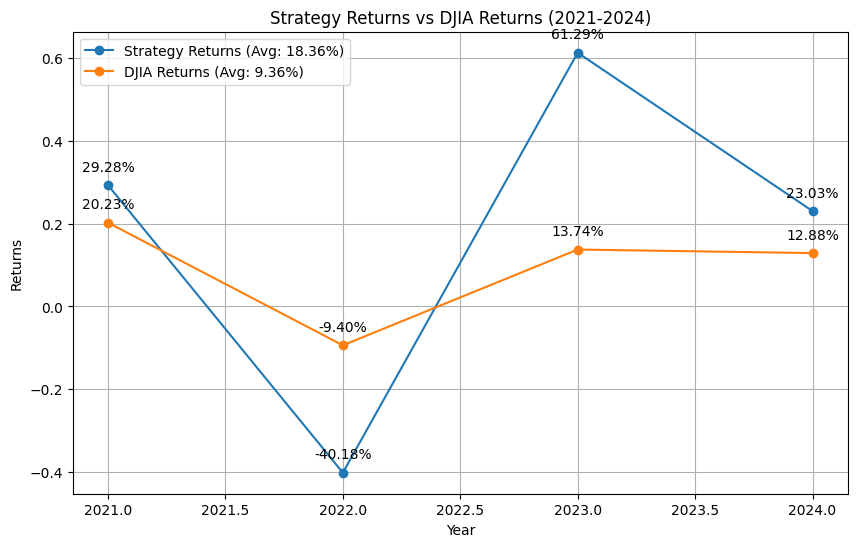

In [208]:
# Final clean tab of results and plot for 2021-2024 Trading Strategy

strategy_returns = []
djia_returns = []
years = []

for year in range(2021, 2025):
    returns = compute_strategy_returns(
        prediction_file=f"trading_strat_data/{year}_returns_predictions/{year}_by_predicted.csv",
        djia_file="trading_strat_data/yearly_djia_returns.csv",
        year=year
    )
    strategy_returns.append(returns[0])
    djia_returns.append(returns[1])
    years.append(year)

# Calculate average returns
avg_strategy_return = sum(strategy_returns) / len(strategy_returns)
avg_djia_return = sum(djia_returns) / len(djia_returns)

# Print the summary results
print("\n--- 2021-2024 Trading Strategy Results ---")
print(f"\nAverage Strategy Return: {avg_strategy_return * 100:.2f}% | "
      f"Average DJIA Return: {avg_djia_return * 100:.2f}% | "
      f"Average Excess Return: {(avg_strategy_return - avg_djia_return) * 100:.2f}%")



# Plot the results
plt.figure(figsize=(10, 6))

# Prepare formatted percentage labels
strategy_returns_pct = [f'{ret * 100:.2f}%' for ret in strategy_returns]
djia_returns_pct = [f'{ret * 100:.2f}%' for ret in djia_returns]

# Plot Strategy Returns
plt.plot(years, strategy_returns, label=f'Strategy Returns (Avg: {avg_strategy_return * 100:.2f}%)', marker='o')
for i, txt in enumerate(strategy_returns_pct):
    plt.annotate(txt, (years[i], strategy_returns[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Plot DJIA Returns
plt.plot(years, djia_returns, label=f'DJIA Returns (Avg: {avg_djia_return * 100:.2f}%)', marker='o')
for i, txt in enumerate(djia_returns_pct):
    plt.annotate(txt, (years[i], djia_returns[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Strategy Returns vs DJIA Returns (2021-2024)')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()
